### Experiment 1 Bondville summary:
1. import bird model ghi values
2. import actual data
3. merge the two based on the common timestamps
4. drop all rows if 'ghi' value is 0
5. Drop all rows with dw_solar < 0
6. Manage missing values: Drop any row if it has -9999.9
7. Make Kt column ('dw_solar'/'ghi') 
8. Group the data into hourly format (by finding mean)
9. assign hierarchical index
10. get the subdataframes for each day and shift the Kt values
11. drop the year, month, day, hour and minute columns
12. feed the data into RNN alrogithm
    - RNN seq_lenth = 1
    - learning rate = 0.001
    - single RNN layer
    - num of epochs = 1000

** in this experiment we are not giving Kt as one of the features. We are using hierarchical index to make sub dataframe for every day and then shift the Kt values one cell up to make it as one hour forecast. **

### NOTE
** the test['Kt'].max() values after grouping into hourly data is 7279.907547 = this is a outlier. The reason might be having a dw_solar reading with QC=2 value. Still haven't checked that. But the second highest value of 'Kt' parameter in the testset is 672 (which is way lower) **

In [44]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO 

### NREL Bird Model implementation: for obtaining clear sky GHI

In [45]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [46]:
%matplotlib inline
sns.set_color_codes()

In [47]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [48]:
bvl = Location(40.1134,-88.3695, 'US/Central', 217.932, 'Bondville')

In [109]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=bvl.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=bvl.tz)   # 24 months of 2010 and 2011 - For training

In [111]:
cs_2009 = bvl.get_clearsky(times2009) 
cs_2010and2011 = bvl.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [112]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [113]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [114]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [115]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [116]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [117]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [118]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [119]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-06:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-06:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-06:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-06:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-06:00,0.0,2010,1,1,0,4


In [93]:
cs_2009.head()

,index,ghi,year,month,day,hour,min
0,2009-01-01 00:00:00-06:00,0.0,2009,1,1,0,0
1,2009-01-01 00:01:00-06:00,0.0,2009,1,1,0,1
2,2009-01-01 00:02:00-06:00,0.0,2009,1,1,0,2
3,2009-01-01 00:03:00-06:00,0.0,2009,1,1,0,3
4,2009-01-01 00:04:00-06:00,0.0,2009,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [120]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [60]:
path = r'.\\data\\Bondville\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1050402, 48)

In [61]:
df_big_train.head()

,year,jday,month,day,hour,min,dt,zen,dw_solar,dw_solar_QC,...,temp,temp_QC,rh,rh_QC,windspd,windspd_QC,winddir,winddir_QC,pressure,pressure_QC
0,2010,1,1,1,0,0,0.000,105.07,-4.1,0,...,-8.9,0,75.9,0,6.4,0,304.1,0,996.1,0
1,2010,1,1,1,0,1,0.017,105.25,-4.1,0,...,-8.9,0,75.7,0,6.5,0,302.6,0,996.1,0
2,2010,1,1,1,0,2,0.033,105.44,-4.1,0,...,-8.9,0,75.7,0,6.6,0,301.5,0,996.2,0
3,2010,1,1,1,0,3,0.050,105.62,-4.1,0,...,-8.9,0,75.6,0,6.9,0,301.4,0,996.2,0
4,2010,1,1,1,0,4,0.067,105.80,-4.1,0,...,-8.9,0,75.8,0,6.7,0,302.8,0,996.2,0


In [121]:
path = r'.\\data\\Bondville\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(524936, 48)

In [122]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(19, 48)

### Merging Clear Sky GHI And the big dataframe

In [123]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1050402, 50)

In [102]:
df_big_test.head()

,year,jday,month,day,hour,min,dt,zen,dw_solar,dw_solar_QC,...,temp,temp_QC,rh,rh_QC,windspd,windspd_QC,winddir,winddir_QC,pressure,pressure_QC
0,2016,1,1,1,0,0,0.000,105.13,-3.4,0,...,-2.2,0,76.5,0,6.8,0,270.0,0,1001.5,0
1,2016,1,1,1,0,1,0.017,105.32,-3.6,0,...,-2.2,0,76.1,0,6.4,0,268.2,0,1001.5,0
2,2016,1,1,1,0,2,0.033,105.50,-3.6,0,...,-2.2,0,77.3,0,6.0,0,272.1,0,1001.5,0
3,2016,1,1,1,0,3,0.050,105.68,-3.7,0,...,-2.2,0,76.7,0,6.6,0,273.9,0,1001.5,0
4,2016,1,1,1,0,4,0.067,105.86,-3.8,0,...,-2.2,0,77.0,0,6.0,0,278.4,0,1001.5,0


In [107]:
cs_2009.head()

,index,ghi,year,month,day,hour,min
0,2009-01-01 00:00:00-06:00,0.0,2009,1,1,0,0
1,2009-01-01 00:01:00-06:00,0.0,2009,1,1,0,1
2,2009-01-01 00:02:00-06:00,0.0,2009,1,1,0,2
3,2009-01-01 00:03:00-06:00,0.0,2009,1,1,0,3
4,2009-01-01 00:04:00-06:00,0.0,2009,1,1,0,4


In [126]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(524936, 50)

In [127]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [128]:
df_train.shape

(1050402, 49)

### Managing missing values

In [129]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [130]:
# Dropping rows with two or more -9999.9 values in columns

In [131]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(1046527, 49)

In [132]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(516826, 49)

In [133]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [134]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [135]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [136]:
len(one_miss_train_idx)

24739

In [137]:
df_train.shape

(1046527, 49)

In [138]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [139]:
df_col_min = df_train.apply(min, axis=0)
df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [140]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [141]:
len(train)

0

In [142]:
# doing the same thing on test dataset

In [143]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

15271

In [144]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [145]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [146]:
len(test)

0

In [147]:
df_train.shape

(1046527, 49)

In [148]:
df_test.shape

(516826, 49)

### Exploratory Data Analysis

In [149]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

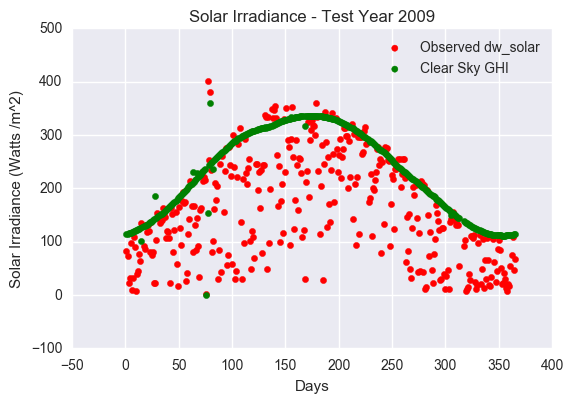

In [150]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2.png', bbox_inches = 'tight')

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


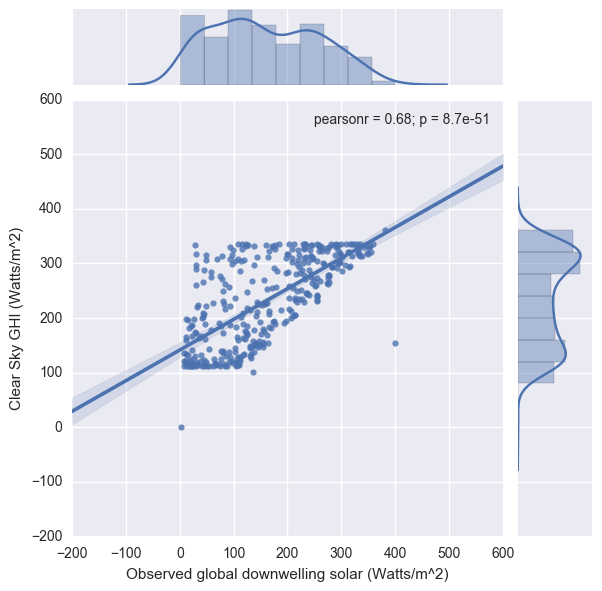

In [151]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure 3', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [152]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [153]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [154]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 44687.079003
test Kt min: -869.110494468
test Kt mean: 2.789494437955276


train Kt max: 13966.2364604
train Kt min: -1176.76984694
train Kt mean: 2.4471862343120523


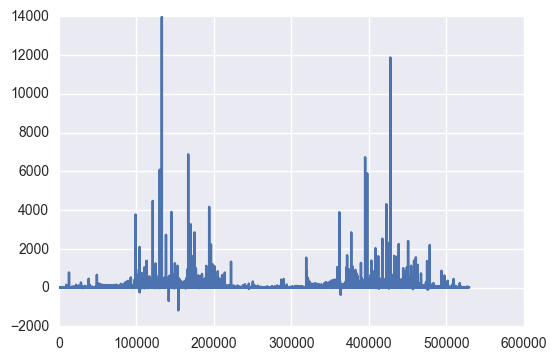

In [155]:
plt.plot(df_train['Kt'])

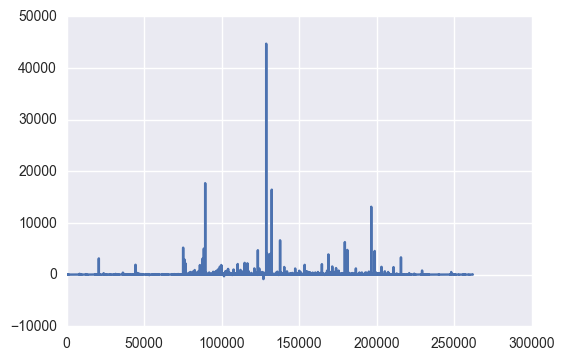

In [156]:
plt.plot(df_test['Kt'])

In [157]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [158]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [159]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [160]:
df_new_train.head()

zen  dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                       
2010.0 1.0   1.0 7.0   152.659762 -4.019048  0.026190  1.554762 -0.202381   
                 8.0   143.730167 -3.900000  0.030000  1.731667 -0.200000   
                 9.0   132.476167 -3.825000  0.011667  1.841667 -0.200000   
                 10.0  121.024000 -3.793333 -0.003333  1.783333 -0.210000   
                 11.0  109.724667 -3.703333  0.006667  1.758333 -0.210000   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 7.0   182.345238   261.159524   260.650000  253.014286   
                 8.0   181.795000   260.780000   260.283333  251.493333   
                 9.0   181.033333   260.256667   259.761667  249.923333   
                 10.0  183.566667   259.941667   259.446667  249.775000   
                 11.0  191.770000   259.800000   259.353333  250.373333   

                       uw_casetemp    ...     netsolar      netir   totalnet  \
year   month day hour                 ...                                      
2010.0 1.0   1.0 7.0    259.557143    ...          0.0 -70.657143 -70.657143   
                 8.0    259.196667    ...          0.0 -69.693333 -69.693333   
                 9.0    258.665000    ...          0.0 -68.890000 -68.890000   
                 10.0   258.315000    ...          0.0 -66.203333 -66.203333   
                 11.0   258.070000    ...          0.0 -58.600000 -58.600000   

                            temp         rh   windspd     winddir  \
year   month day hour                                               
2010.0 1.0   1.0 7.0  -13.607143  83.883333  5.145238  293.504762   
                 8.0  -13.956667  84.893333  4.805000  296.086667   
                 9.0  -14.476667  85.781667  4.898333  295.981667   
                 10.0 -14.826667  85.966667  5.083333  298.381667   
                 11.0 -15.123333  86.431667  4.973333  299.090000   

                          pressure         ghi        Kt  
year   month day hour                                     
2010.0 1.0   1.0 7.0    999.397619   61.060726 -0.069829  
                 8.0    999.803333  166.338212 -0.025197  
                 9.0    999.783333  306.455432 -0.012680  
                 10.0   999.968333  411.028556 -0.009267  
                 11.0  1000.193333  465.002071 -0.007967  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [161]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [162]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [163]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
6.0,150.182143,-4.521429,-0.471429,1.007143,0.421429,216.700000,272.085714,271.642857,286.392857,270.300000,...,0.000000,-69.692857,-69.692857,-2.271429,89.750000,2.871429,174.300000,998.471429,37.874247,-0.120932
7.0,146.446833,-4.301667,-0.345000,0.326667,0.518333,216.170000,271.606667,271.146667,284.053333,269.938333,...,0.000000,-67.881667,-67.881667,-2.773333,92.965000,3.066667,146.796667,997.966667,108.318844,-0.050473
8.0,137.938333,-4.831667,-0.351667,1.045000,0.490000,216.516667,271.153333,270.733333,288.993333,269.398333,...,0.000000,-72.466667,-72.466667,-3.256667,94.690000,3.873333,152.585000,996.900000,284.228645,-0.017408
9.0,127.563000,-5.281667,-0.308333,0.951667,0.436667,223.628333,271.841667,271.390000,294.260000,269.860000,...,0.000000,-70.631667,-70.631667,-2.865000,91.560000,4.900000,164.426667,995.828333,448.178675,-0.011885
10.0,116.367333,-5.035000,-0.243333,0.833333,0.373333,236.190000,272.423333,271.983333,296.791667,270.326667,...,0.000000,-60.611667,-60.611667,-2.485000,89.688333,4.981667,173.578333,995.345000,570.306262,-0.008854
11.0,104.909333,-5.066667,-0.135000,0.480000,0.401667,233.243333,272.581667,272.093333,297.226667,270.480000,...,0.000000,-63.985000,-63.985000,-2.386667,92.431667,5.595000,167.585000,994.613333,638.422279,-0.007937
12.0,93.430833,-2.668333,0.580000,1.250000,3.091667,238.826667,272.686667,272.196667,298.433333,270.543333,...,2.351667,-59.603333,-57.251667,-2.320000,92.493333,6.421667,167.895000,993.798333,646.734117,-0.004067
13.0,82.473333,50.488333,14.828333,7.531667,57.045000,245.631667,273.396667,272.983333,302.830000,271.061667,...,43.403333,-57.188333,-13.786667,-1.801667,91.796667,6.791667,167.960000,993.278333,594.568596,0.086837
14.0,72.405000,136.151667,36.918333,13.550000,140.373333,286.001667,275.108333,274.810000,312.523333,272.315000,...,107.461667,-26.526667,80.938333,-0.561667,101.838333,7.736667,175.430000,992.623333,486.293072,0.287014


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [164]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [165]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-1)

In [166]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [167]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [168]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-1)

In [169]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [170]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
8.0,5.0,19.0,30.434833,800.548333,153.193333,601.871667,280.84,384.561667,304.885,304.643333,482.225,302.208333,...,645.503333,-97.671667,547.838333,26.02,63.08,2.26,103.323333,992.138333,44.570245,1146.230573


### Normalize train and test dataframe

In [171]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [172]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [173]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  from ipykernel import kernelapp as app


2

In [174]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [175]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [176]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [177]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9600, 22)
y1_train shape is (9600,)
X2_test shape is (4400, 22)
y2_test shape is (4400,)


In [178]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [179]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [180]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [181]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [188]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
               
        optimizer.zero_grad()
        
        outputs = model(features)
        
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        n_iter += 1  
        test_batch_mse =list()    
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                #mse_old = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                test_batch_mse.append(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2))
            test_iter.append(n_iter)
            test_loss.append(np.mean(test_batch_mse))
            
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], test_loss[-1]))
               

Epoch: 1 Iteration: 100. Train_MSE: 0.009215903468430042. Test_MSE: 0.00529575115069747
Epoch: 2 Iteration: 200. Train_MSE: 0.0061593265272676945. Test_MSE: 0.004371232353150845
Epoch: 3 Iteration: 300. Train_MSE: 0.0027144080959260464. Test_MSE: 0.003831080161035061
Epoch: 4 Iteration: 400. Train_MSE: 0.0037528714165091515. Test_MSE: 0.0034912065602838993
Epoch: 5 Iteration: 500. Train_MSE: 0.0038438993506133556. Test_MSE: 0.003262390149757266
Epoch: 6 Iteration: 600. Train_MSE: 0.013666358776390553. Test_MSE: 0.0030873597133904696
Epoch: 7 Iteration: 700. Train_MSE: 0.003519519465044141. Test_MSE: 0.0029423863161355257
Epoch: 8 Iteration: 800. Train_MSE: 0.0021539567969739437. Test_MSE: 0.0028148391284048557
Epoch: 9 Iteration: 900. Train_MSE: 0.0038854663725942373. Test_MSE: 0.002696497831493616
Epoch: 10 Iteration: 1000. Train_MSE: 0.003347498131915927. Test_MSE: 0.002590596443042159
Epoch: 11 Iteration: 1100. Train_MSE: 0.0016097460174933076. Test_MSE: 0.002499358495697379
Epoch: 

Epoch: 94 Iteration: 9000. Train_MSE: 0.0006923566106706858. Test_MSE: 0.0008977365796454251
Epoch: 95 Iteration: 9100. Train_MSE: 0.0007616707589477301. Test_MSE: 0.0008942426065914333
Epoch: 96 Iteration: 9200. Train_MSE: 0.00045754536404274404. Test_MSE: 0.0008908663294278085
Epoch: 97 Iteration: 9300. Train_MSE: 0.0005233740666881204. Test_MSE: 0.0008877204963937402
Epoch: 98 Iteration: 9400. Train_MSE: 0.0003299737290944904. Test_MSE: 0.0008846363052725792
Epoch: 99 Iteration: 9500. Train_MSE: 0.0002837417705450207. Test_MSE: 0.0008815937326289713
Epoch: 101 Iteration: 9600. Train_MSE: 0.0002986669715028256. Test_MSE: 0.00087863759836182
Epoch: 102 Iteration: 9700. Train_MSE: 0.000711488479282707. Test_MSE: 0.0008757598116062582
Epoch: 103 Iteration: 9800. Train_MSE: 0.0004194417269900441. Test_MSE: 0.0008730074041523039
Epoch: 104 Iteration: 9900. Train_MSE: 0.001285469508729875. Test_MSE: 0.0008702652412466705
Epoch: 105 Iteration: 10000. Train_MSE: 0.0008505376172251999. Test_M

Epoch: 186 Iteration: 17700. Train_MSE: 0.009854169562458992. Test_MSE: 0.000767191406339407
Epoch: 187 Iteration: 17800. Train_MSE: 0.002756658708676696. Test_MSE: 0.0007665946613997221
Epoch: 188 Iteration: 17900. Train_MSE: 0.0007388571393676102. Test_MSE: 0.0007660060655325651
Epoch: 189 Iteration: 18000. Train_MSE: 0.00018746600835584104. Test_MSE: 0.0007654139772057533
Epoch: 190 Iteration: 18100. Train_MSE: 0.00014324524090625346. Test_MSE: 0.0007648473838344216
Epoch: 191 Iteration: 18200. Train_MSE: 0.00014211289817467332. Test_MSE: 0.0007642901036888361
Epoch: 192 Iteration: 18300. Train_MSE: 0.0002880804822780192. Test_MSE: 0.0007637492963112891
Epoch: 193 Iteration: 18400. Train_MSE: 0.005023715551942587. Test_MSE: 0.000763204472605139
Epoch: 194 Iteration: 18500. Train_MSE: 0.000511879101395607. Test_MSE: 0.0007626563892699778
Epoch: 195 Iteration: 18600. Train_MSE: 0.0005023300182074308. Test_MSE: 0.0007620945107191801
Epoch: 196 Iteration: 18700. Train_MSE: 0.00031495399

Epoch: 277 Iteration: 26400. Train_MSE: 0.0002578779822215438. Test_MSE: 0.0007323733880184591
Epoch: 278 Iteration: 26500. Train_MSE: 0.00015972153050825. Test_MSE: 0.000732098356820643
Epoch: 279 Iteration: 26600. Train_MSE: 0.0002001359680434689. Test_MSE: 0.0007318176212720573
Epoch: 281 Iteration: 26700. Train_MSE: 0.00017402213416062295. Test_MSE: 0.0007315385737456381
Epoch: 282 Iteration: 26800. Train_MSE: 0.0003655084583442658. Test_MSE: 0.000731250736862421
Epoch: 283 Iteration: 26900. Train_MSE: 0.00025958704645745456. Test_MSE: 0.0007310044602490962
Epoch: 284 Iteration: 27000. Train_MSE: 0.0011263490887358785. Test_MSE: 0.000730725412722677
Epoch: 285 Iteration: 27100. Train_MSE: 0.0007415580912493169. Test_MSE: 0.000730405910871923
Epoch: 286 Iteration: 27200. Train_MSE: 0.009805514477193356. Test_MSE: 0.0007301025907509029
Epoch: 287 Iteration: 27300. Train_MSE: 0.0027576740831136703. Test_MSE: 0.000729825347661972
Epoch: 288 Iteration: 27400. Train_MSE: 0.00068141380324

Epoch: 369 Iteration: 35100. Train_MSE: 0.00011012948380084708. Test_MSE: 0.0007105788099579513
Epoch: 370 Iteration: 35200. Train_MSE: 9.102088370127603e-05. Test_MSE: 0.0007103634416125715
Epoch: 371 Iteration: 35300. Train_MSE: 9.68578751781024e-05. Test_MSE: 0.0007101506926119328
Epoch: 372 Iteration: 35400. Train_MSE: 0.0002103388833347708. Test_MSE: 0.0007099470240063965
Epoch: 373 Iteration: 35500. Train_MSE: 0.005053441505879164. Test_MSE: 0.000709726067725569
Epoch: 374 Iteration: 35600. Train_MSE: 0.00044647775939665735. Test_MSE: 0.0007094877655617893
Epoch: 375 Iteration: 35700. Train_MSE: 0.0004348660004325211. Test_MSE: 0.0007092677406035364
Epoch: 376 Iteration: 35800. Train_MSE: 0.0002648313529789448. Test_MSE: 0.0007090286817401648
Epoch: 377 Iteration: 35900. Train_MSE: 0.00021574206766672432. Test_MSE: 0.0007088001584634185
Epoch: 378 Iteration: 36000. Train_MSE: 0.00014007072604727. Test_MSE: 0.0007085956749506295
Epoch: 379 Iteration: 36100. Train_MSE: 0.0001796148

Epoch: 461 Iteration: 43800. Train_MSE: 0.0001545988052384928. Test_MSE: 0.0006927559152245522
Epoch: 462 Iteration: 43900. Train_MSE: 0.0002703844802454114. Test_MSE: 0.0006925704074092209
Epoch: 463 Iteration: 44000. Train_MSE: 0.0002032625925494358. Test_MSE: 0.0006924162153154612
Epoch: 464 Iteration: 44100. Train_MSE: 0.0010986983543261886. Test_MSE: 0.0006922247703187168
Epoch: 465 Iteration: 44200. Train_MSE: 0.0007182139670476317. Test_MSE: 0.0006920103332959116
Epoch: 466 Iteration: 44300. Train_MSE: 0.009715414606034756. Test_MSE: 0.0006918054423294961
Epoch: 467 Iteration: 44400. Train_MSE: 0.0027279744390398264. Test_MSE: 0.0006916198180988431
Epoch: 468 Iteration: 44500. Train_MSE: 0.0006292675388976932. Test_MSE: 0.0006914368132129312
Epoch: 469 Iteration: 44600. Train_MSE: 9.723983384901658e-05. Test_MSE: 0.0006912645767442882
Epoch: 470 Iteration: 44700. Train_MSE: 8.240318129537627e-05. Test_MSE: 0.000691085762809962
Epoch: 471 Iteration: 44800. Train_MSE: 8.5711122665

Epoch: 552 Iteration: 52500. Train_MSE: 0.00017667053907644004. Test_MSE: 0.000677793228533119
Epoch: 553 Iteration: 52600. Train_MSE: 0.005037065129727125. Test_MSE: 0.0006776329246349633
Epoch: 554 Iteration: 52700. Train_MSE: 0.00041427568066865206. Test_MSE: 0.0006774517241865396
Epoch: 555 Iteration: 52800. Train_MSE: 0.0004136764910072088. Test_MSE: 0.0006772944470867515
Epoch: 556 Iteration: 52900. Train_MSE: 0.0002457935188431293. Test_MSE: 0.0006771222106181085
Epoch: 557 Iteration: 53000. Train_MSE: 0.00017290317919105291. Test_MSE: 0.0006769562023691833
Epoch: 558 Iteration: 53100. Train_MSE: 0.0001184601424029097. Test_MSE: 0.0006768137100152671
Epoch: 559 Iteration: 53200. Train_MSE: 0.00014809893036726862. Test_MSE: 0.0006766620790585876
Epoch: 561 Iteration: 53300. Train_MSE: 0.0001425700611434877. Test_MSE: 0.0006765059661120176
Epoch: 562 Iteration: 53400. Train_MSE: 0.00023826291726436466. Test_MSE: 0.0006763517740182579
Epoch: 563 Iteration: 53500. Train_MSE: 0.00018

Epoch: 644 Iteration: 61200. Train_MSE: 0.0010770998196676373. Test_MSE: 0.000665039464365691
Epoch: 645 Iteration: 61300. Train_MSE: 0.0006980226025916636. Test_MSE: 0.0006648778216913342
Epoch: 646 Iteration: 61400. Train_MSE: 0.009638851508498192. Test_MSE: 0.0006647256668657064
Epoch: 647 Iteration: 61500. Train_MSE: 0.0026963907293975353. Test_MSE: 0.0006645885296165943
Epoch: 648 Iteration: 61600. Train_MSE: 0.0006014234386384487. Test_MSE: 0.0006644558743573725
Epoch: 649 Iteration: 61700. Train_MSE: 8.413449540967122e-05. Test_MSE: 0.0006643327651545405
Epoch: 650 Iteration: 61800. Train_MSE: 7.185893628047779e-05. Test_MSE: 0.0006642014486715198
Epoch: 651 Iteration: 61900. Train_MSE: 7.153882324928418e-05. Test_MSE: 0.0006640739156864583
Epoch: 652 Iteration: 62000. Train_MSE: 0.0001632421772228554. Test_MSE: 0.0006639553466811776
Epoch: 653 Iteration: 62100. Train_MSE: 0.005028051324188709. Test_MSE: 0.0006638194900006056
Epoch: 654 Iteration: 62200. Train_MSE: 0.00040139301

Epoch: 735 Iteration: 69900. Train_MSE: 0.00040099964826367795. Test_MSE: 0.0006539392052218318
Epoch: 736 Iteration: 70000. Train_MSE: 0.00023398787016049027. Test_MSE: 0.0006538088200613856
Epoch: 737 Iteration: 70100. Train_MSE: 0.00014714228746015579. Test_MSE: 0.0006536837317980826
Epoch: 738 Iteration: 70200. Train_MSE: 0.00010360073065385222. Test_MSE: 0.0006535808206535876
Epoch: 739 Iteration: 70300. Train_MSE: 0.000125491336802952. Test_MSE: 0.0006534683052450418
Epoch: 741 Iteration: 70400. Train_MSE: 0.00012308942677918822. Test_MSE: 0.000653350492939353
Epoch: 742 Iteration: 70500. Train_MSE: 0.00019864144269376993. Test_MSE: 0.0006532368715852499
Epoch: 743 Iteration: 70600. Train_MSE: 0.00015023394371382892. Test_MSE: 0.0006531495018862188
Epoch: 744 Iteration: 70700. Train_MSE: 0.0010681124404072762. Test_MSE: 0.0006530226673930883
Epoch: 745 Iteration: 70800. Train_MSE: 0.0006877745618112385. Test_MSE: 0.0006528804660774767
Epoch: 746 Iteration: 70900. Train_MSE: 0.009

Epoch: 827 Iteration: 78600. Train_MSE: 0.0026692866813391447. Test_MSE: 0.0006442267331294715
Epoch: 828 Iteration: 78700. Train_MSE: 0.0005842018290422857. Test_MSE: 0.0006441258592531085
Epoch: 829 Iteration: 78800. Train_MSE: 7.555199408670887e-05. Test_MSE: 0.0006440334254875779
Epoch: 830 Iteration: 78900. Train_MSE: 6.51939699309878e-05. Test_MSE: 0.0006439329590648413
Epoch: 831 Iteration: 79000. Train_MSE: 6.14919772488065e-05. Test_MSE: 0.000643835635855794
Epoch: 832 Iteration: 79100. Train_MSE: 0.00014520456898026168. Test_MSE: 0.0006437466945499182
Epoch: 833 Iteration: 79200. Train_MSE: 0.005015681963413954. Test_MSE: 0.0006436404655687511
Epoch: 834 Iteration: 79300. Train_MSE: 0.00038319395389407873. Test_MSE: 0.0006435122922994196
Epoch: 835 Iteration: 79400. Train_MSE: 0.00039588246727362275. Test_MSE: 0.0006434108945541084
Epoch: 836 Iteration: 79500. Train_MSE: 0.0002283106732647866. Test_MSE: 0.0006432961672544479
Epoch: 837 Iteration: 79600. Train_MSE: 0.000136088

Epoch: 918 Iteration: 87300. Train_MSE: 9.280457015847787e-05. Test_MSE: 0.0006357164238579571
Epoch: 919 Iteration: 87400. Train_MSE: 0.00010899025073740631. Test_MSE: 0.0006356294034048915
Epoch: 921 Iteration: 87500. Train_MSE: 0.00010772120003821328. Test_MSE: 0.0006355361547321081
Epoch: 922 Iteration: 87600. Train_MSE: 0.00017305446090176702. Test_MSE: 0.0006354487268254161
Epoch: 923 Iteration: 87700. Train_MSE: 0.0001285634789383039. Test_MSE: 0.0006353860371746123
Epoch: 924 Iteration: 87800. Train_MSE: 0.0010547521524131298. Test_MSE: 0.0006352838245220482
Epoch: 925 Iteration: 87900. Train_MSE: 0.0006726133287884295. Test_MSE: 0.0006351673509925604
Epoch: 926 Iteration: 88000. Train_MSE: 0.009544490836560726. Test_MSE: 0.0006350578623823822
Epoch: 927 Iteration: 88100. Train_MSE: 0.002656170167028904. Test_MSE: 0.0006349632749333978
Epoch: 928 Iteration: 88200. Train_MSE: 0.0005772770964540541. Test_MSE: 0.0006348754977807403
Epoch: 929 Iteration: 88300. Train_MSE: 7.1632173

950


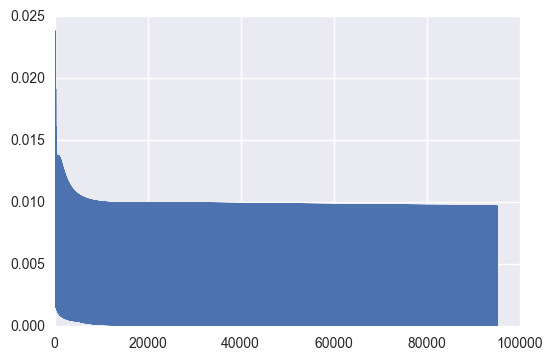

In [189]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


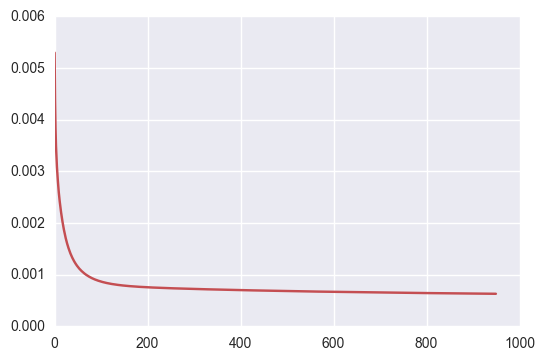

In [190]:
plt.plot(test_loss,'r')

#### Demornamization

In [191]:
rmse = np.sqrt(test_loss[-1])

In [192]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [193]:
rmse_denorm

34.131595733546838

In [194]:
df_new_test['Kt'].describe()

count    4362.000000
mean        5.380703
std        29.307744
min        -0.203877
25%        -0.008714
50%         0.102974
75%         1.071525
max      1146.230573
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [195]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss}, columns=['Train Loss'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_Bondville_1000Epoch_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss}, columns=['Test Loss'])
df_testLoss.to_csv('RNN Paper Results/Exp1_Bondville_1000EpochTestLoss.csv')